In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import torch
import torch.nn as nn
import pandas_profiling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline
df=pd.read_csv('/Users/asadmolayari/Desktop/my_courses/pytorch/Data/income.csv')
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
age               30000 non-null int64
sex               30000 non-null object
education         30000 non-null object
education-num     30000 non-null int64
marital-status    30000 non-null object
workclass         30000 non-null object
occupation        30000 non-null object
hours-per-week    30000 non-null int64
income            30000 non-null object
label             30000 non-null int64
dtypes: int64(4), object(6)
memory usage: 2.3+ MB


In [5]:
pandas_profiling.ProfileReport(df)

In [6]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [2]:

cat_cols = ['sex', 'education',  'marital-status','workclass', 'occupation']
cont_cols = ['age','hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [3]:
for col in cat_cols:
    df[col]=df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
age               30000 non-null int64
sex               30000 non-null category
education         30000 non-null category
education-num     30000 non-null int64
marital-status    30000 non-null category
workclass         30000 non-null category
occupation        30000 non-null category
hours-per-week    30000 non-null int64
income            30000 non-null object
label             30000 non-null int64
dtypes: category(5), int64(4), object(1)
memory usage: 1.3+ MB


In [4]:
#shuffling the data
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head(5)

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [5]:
#embedding
cat_szs=[len(df[col].cat.categories) for col in cat_cols]

emb_szs=[(size, min(size//2, 50)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 2), (12, 6)]

In [6]:
#stacking the categorical variables together
cats=np.stack([df[col].cat.codes.values for col in cat_cols],1)

cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [7]:
# converting to tensor
cats = torch.tensor(cats,dtype=torch.int64)
cats[:5]

tensor([[ 0, 10,  3,  2,  6],
        [ 0, 12,  1,  4,  7],
        [ 1, 13,  0,  2,  0],
        [ 1, 10,  1,  2,  1],
        [ 0, 13,  3,  2,  9]])

In [8]:
#stacking the continuous values and convertin to tensor
conts=np.stack([df[col].values for col in cont_cols],1)
conts=torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[23., 50.],
        [37., 39.],
        [34., 40.],
        [31., 40.],
        [20., 25.]])

In [9]:
y=torch.tensor(df[y_col].values).flatten()
y

tensor([0, 1, 0,  ..., 1, 0, 1])

In [10]:
# CODE HERE
b = 30000 # suggested batch size
t = 5000  # suggested test size

train_cats = cats[:b-t]
train_conts = conts[:b-t]

test_cats = cats[b-t:b]
test_conts = conts[b-t:b]

y_train = y[:b-t]
y_test = y[b-t:b]



In [11]:
train_cats.shape

torch.Size([25000, 5])

In [12]:
train_conts.shape

torch.Size([25000, 2])

In [13]:
test_cats.shape

torch.Size([5000, 5])

In [20]:
y_train.shape

torch.Size([25000])

#using the Tabular model from Jose Portilla's course on Udemy

In [16]:
class TabularModel(nn.Module):
    def __init__(self,emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace =True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
            
        x = torch.cat(embeddings, 1)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        x=self.layers(x)
        return x


In [17]:
model = TabularModel(emb_szs, conts.shape[1] , 2, [50], p=0.4) 
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 2)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [18]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.001)

In [19]:
import time
start_time = time.time()

epochs = 400
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(train_cats, train_conts)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    if i%25 ==1:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1 loss: 0.79948282
epoch:  26 loss: 0.49264628


KeyboardInterrupt: 

Text(0, 0.5, 'losses')

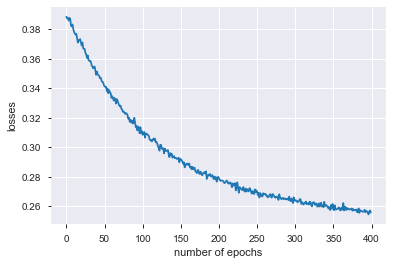

In [75]:
plt.plot(range(epochs), losses)
plt.xlabel('number of epochs')
plt.ylabel('losses')


### 14. Evaluate the test set
With torch set to <tt>no_grad</tt>, pass <tt>cat_test</tt> and <tt>con_test</tt> through the trained model. Create a validation set called "y_val". Compare the output to <tt>y_test</tt> using the loss function defined above. Results may vary.

In [79]:
with torch.no_grad():
    y_val = model(test_cats, test_conts)
    loss=criterion(y_val, y_test)
loss

tensor(0.2835)

### 15. Calculate the overall percent accuracy
Using a for loop, compare the argmax values of the <tt>y_val</tt> validation set to the <tt>y_test</tt> set.

In [84]:
correct=0

for i in range(len(y_test)):
    
    if y_val[i].argmax()==y_test[i]:
        correct+=1
        
print(f'the accuracy is : {100*correct/len(y_val)}')        

the accuracy is : 87.0


### BONUS: Feed new data through the trained model
See if you can write a function that allows a user to input their own values, and generates a prediction.<br>
<strong>HINT</strong>:<br>There's no need to build a DataFrame. You can use inputs to populate column variables, convert them to embeddings with a context dictionary, and pass the embedded values directly into the tensor constructors:<br>
<pre>mar = input("What is the person's marital status? ")
mar_d = dict(Divorced=0, Married=1, Married-spouse-absent=2, Never-married=3, Separated=4, Widowed=5)
mar = mar_d[mar]
cats = torch.tensor([..., ..., mar, ..., ...], dtype=torch.int64).reshape(1,-1)</pre>
Make sure that names are put in alphabetical order before assigning numbers.

Also, be sure to run <tt>model.eval()</tt> before passing new date through. Good luck!

In [97]:
mar = input("enter your maritial status ")
age = input("enter your age ")
education = input("enter your education ")
sex = input("enter your sex ")
workclass = input("enter your workclass ")
occupation = input("enter your occupation ")
hours_per_week = input("enter your hours-per-week ")

enter your maritial status m
enter your age 35
enter your education master
enter your sex m
enter your workclass private
enter your occupation engineer
enter your hours-per-week 40


In [91]:
mar_d = {'Divorced'=0, 'Married'=1, 'Married_spouse_absent'=2, 'Never_married'=3, 'Separated'=4, 'Widowed'=5}
edu_d = {'Divorced'=0, 'Married'=1, 'Married_spouse_absent'=2, 'Never_married'=3, 'Separated'=4, 'Widowed'=5}
sex_d = {'Divorced'=0, 'Married'=1, 'Married_spouse_absent'=2, 'Never_married'=3, 'Separated'=4, 'Widowed'=5}
workclass_d = {'Divorced'=0, 'Married'=1, 'Married_spouse_absent'=2, 'Never_married'=3, 'Separated'=4, 'Widowed'=5}
occu_d = {'Divorced'=0, 'Married'=1, 'Married_spouse_absent'=2, 'Never_married'=3, 'Separated'=4, 'Widowed'=5}
hr_per_week_d = {'Divorced'=0, 'Married'=1, 'Married_spouse_absent'=2, 'Never_married'=3, 'Separated'=4, 'Widowed'=5}

In [103]:
df.education.cat.categories

Index(['10th', '11th', '12th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm',
       'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters',
       'Prof-school', 'Some-college'],
      dtype='object')